<a href="https://colab.research.google.com/github/iprameshwari/hacktiv8/blob/main/PYIM_Assgn_2_8_Irma_Prameshwari.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library


In [1]:
import os
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import os.path
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import confusion_matrix, classification_report


import seaborn as sns


# Import Data

Mendownload data dari link sumbernya dengan menggunakan *!wget* sehingga data akan tersimpan pada folder di colab.

Kemudian, data .zip akan di-unzip menggunakan *!unzip*

In [3]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
!unzip kagglecatsanddogs_3367a.zip

--2021-06-26 05:25:22--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 92.123.124.137, 2a02:26f0:b200:2bf::e59, 2a02:26f0:b200:2b5::e59
Connecting to download.microsoft.com (download.microsoft.com)|92.123.124.137|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_3367a.zip.4’

kagglecatsanddogs_3 100%[===================>] 786.68M   293MB/s    in 2.7s    

2021-06-26 05:25:24 (293 MB/s) - ‘kagglecatsanddogs_3367a.zip.4’ saved [824894548/824894548]

Archive:  kagglecatsanddogs_3367a.zip
replace PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Menghapus data yang *corrupt*
Sebelum melakukan percobaan menjalankan model, disarankan untuk mengecek terlebih dahulu apakah terdapat file dari dataframe yang tidak dapat dibuka atau corrupt. Dan apabila terdapat data yang *corrupt* agar langsung dihapus sebelum memulai pemrosesan training data.

In [4]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


#Membuat File DataFrame

Membaca isi dari folder dan menyimpannya dalam bentuk DataFrame.

In [5]:
dir_image = Path('PetImages')
filepaths = list(dir_image.glob(r'**/*.jpg'))
labels=list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [6]:
 filepaths =pd.Series(filepaths, name='Filepath').astype(str)
 labels = pd.Series(labels, name='Label')
 image_df = pd.concat([filepaths, labels], axis = 1)

In [7]:
train_df, test_df = train_test_split(image_df, train_size=0.8, shuffle=True, random_state=1)

# Load Image Data
Pertama-tama, membuat ImageDataGenerator untuk training dan test dataset.

In [8]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

In [9]:
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

membuat dataset training, validation, dan test.

In [10]:
train_ds = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

Found 14983 validated image filenames belonging to 2 classes.


In [11]:
val_ds = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 3745 validated image filenames belonging to 2 classes.


In [12]:
test_ds = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

Found 4682 validated image filenames belonging to 2 classes.


# Visualisasi Data

Untuk memperlihatkan data sebelum melakukan proses model dan training

In [35]:
class_names=train_ds.class_indices

new_dict={}

for key, value in class_names.items():
    new_dict[value]=key 
new_dict

{0: 'Cat', 1: 'Dog'}

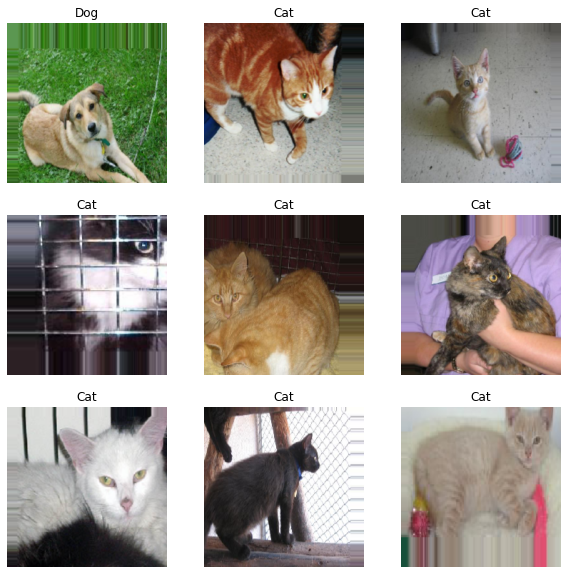

In [34]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  image,label = train_ds.next()
  plt.imshow(image[0])
  label_name = new_dict[label[0]]
  plt.title(label_name)
  plt.axis('off')
  plt.show

# Pembuatan model dan training


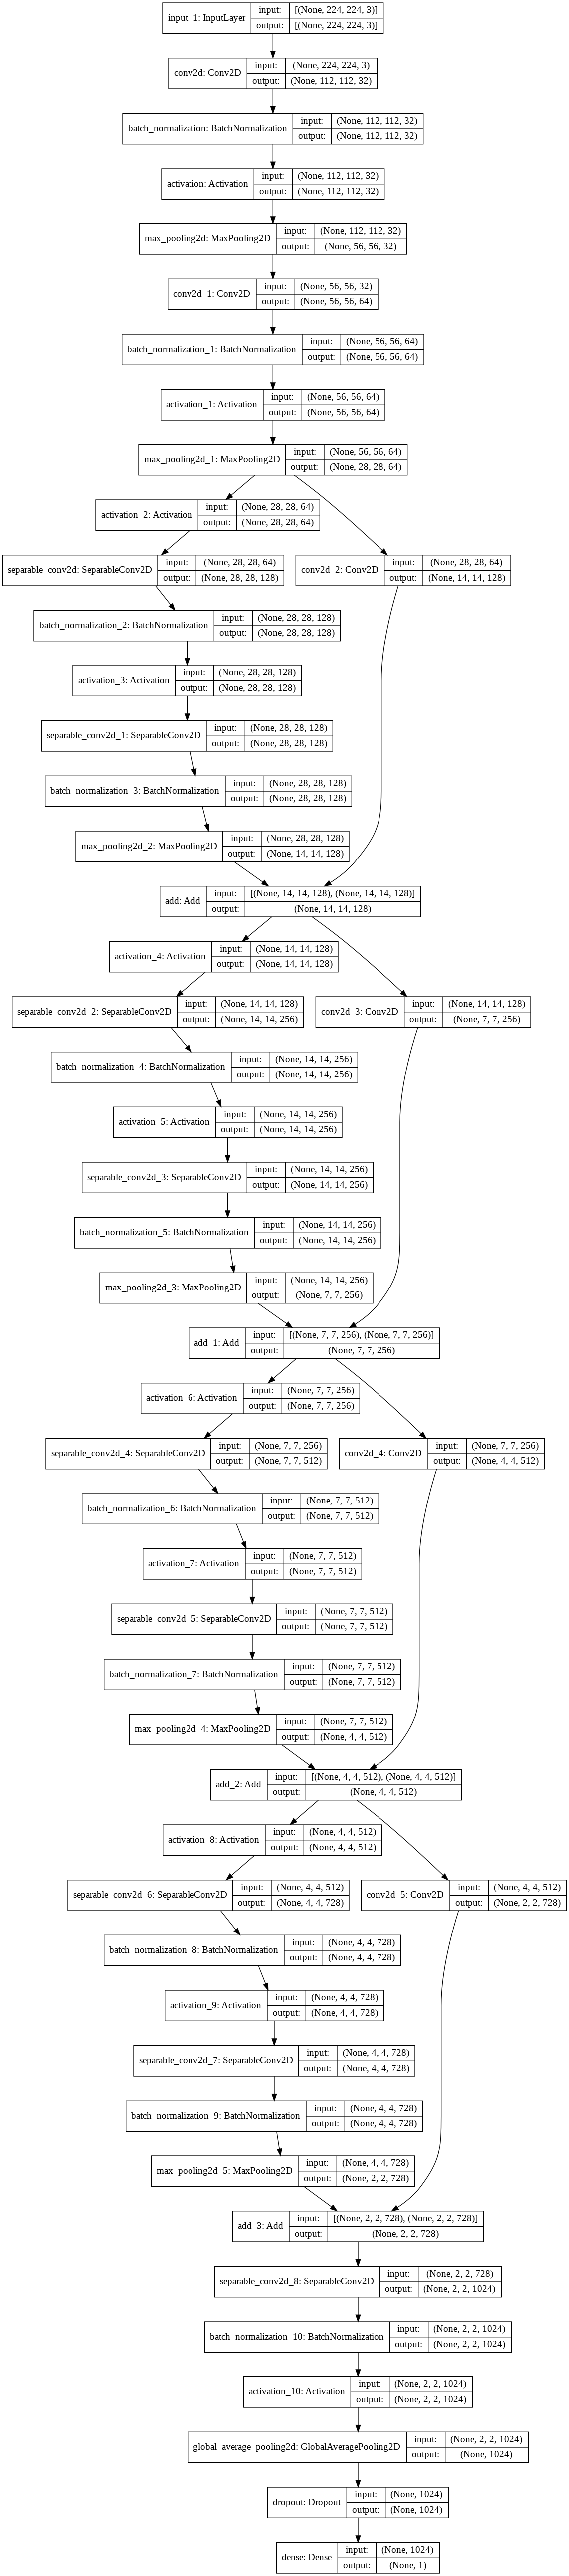

In [36]:
# pembuatan model

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.MaxPool2D()(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

# visualisasi model
model = make_model(input_shape=(224,224) + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [37]:
# Kompilasi Model

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


# Melakukan fitting Model
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=10,
    callbacks=[
              tf.keras.callbacks.EarlyStopping(
                  monitor='val_loss',
                  patience = 5,
                  restore_best_weights = True
              )
    ])


Epoch 1/10
469/469 [==============================] - 224s 469ms/step - loss: 0.6095 - accuracy: 0.6762 - val_loss: 0.7936 - val_accuracy: 0.5097
Epoch 2/10
469/469 [==============================] - 226s 481ms/step - loss: 0.4788 - accuracy: 0.7757 - val_loss: 0.8074 - val_accuracy: 0.6083
Epoch 3/10
469/469 [==============================] - 228s 486ms/step - loss: 0.4073 - accuracy: 0.8168 - val_loss: 0.6280 - val_accuracy: 0.7089
Epoch 4/10
469/469 [==============================] - 224s 477ms/step - loss: 0.3533 - accuracy: 0.8462 - val_loss: 0.8291 - val_accuracy: 0.6788
Epoch 5/10
469/469 [==============================] - 223s 477ms/step - loss: 0.3050 - accuracy: 0.8664 - val_loss: 0.3767 - val_accuracy: 0.8609
Epoch 6/10
469/469 [==============================] - 222s 474ms/step - loss: 0.2784 - accuracy: 0.8835 - val_loss: 0.4002 - val_accuracy: 0.8377
Epoch 7/10
469/469 [==============================] - 220s 470ms/step - loss: 0.2419 - accuracy: 0.8988 - val_loss: 0.3578 -

# Melakukan evaluasi Model dan visualisasi hasil model antara prediksi serta aktual menggunakan dataset test (test_ds)

In [38]:
results = model.evaluate(test_ds, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1]*100))

    Test Loss: 0.49180
Test Accuracy: 81.40%


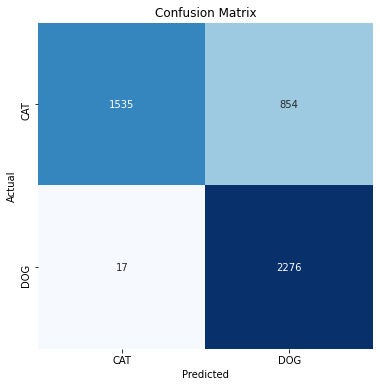

In [39]:
prediction =(model.predict(test_ds)>=0.5).astype(np.int)
cm = confusion_matrix(test_ds.labels,prediction, labels=[0,1])

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar = False)
plt.xticks(ticks=[0.5,1.5], labels=['CAT','DOG'])
plt.yticks(ticks=[0.5,1.5], labels=['CAT','DOG'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Saving model for future predictions
Menyimpan model untuk digunakan di masa yang akan datang

In [40]:
model.save('cat_vs_dog_predictions')


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: cat_vs_dog_predictions/assets
